На цьому етапі дослідів ми більше зосередимося на моделі та способах її покращення.

# Preprocessing

## Split dataset

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv('prep_df.csv').sample(200000)

Початковий задум на етапі розгяляду данних полягає у тому, що кількість користувачів, які приносять дохід, у рази менша за тих, хто дохід не приносить. Проста регресія може мати засильний bias стосовно 0 доходу, то є ідея спочатку класифікувати користувачів на не/дохідних, і уже по однозначним даним будувати регресію. Перевіримо наше припущення на практиці.

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(['target_full_ltv_day30', 'target_ad_ltv_day30', 'target_iap_ltv_day30', 'target_sub_ltv_day30'], axis=1)
y = df[['target_full_ltv_day30', 'target_ad_ltv_day30', 'target_iap_ltv_day30', 'target_sub_ltv_day30']].copy()
y_cl = np.where(y['target_full_ltv_day30'] == 0, 0, 1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, valid_index in sss.split(X, y_cl):
    train_X, valid_X = X.iloc[train_index], X.iloc[valid_index]
    train_y, valid_y = y.iloc[train_index], y.iloc[valid_index]
    train_y_cl, valid_y_cl = y_cl[train_index], y_cl[valid_index]

for train_index, test_index in sss.split(train_X, train_y_cl):
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]
    train_y_cl, test_y_cl = y_cl[train_index], y_cl[test_index]

print(f'Train size: X - {train_X.shape}, y - {train_y.shape}')
print(f'Test size: X - {test_X.shape}, y - {test_y.shape}')
print(f'Valid size: X - {valid_X.shape}, y - {valid_y.shape}')

Train size: X - (128000, 59), y - (128000, 4)
Test size: X - (32000, 59), y - (32000, 4)
Valid size: X - (40000, 59), y - (40000, 4)


In [3]:
cat = [col for col in train_X.columns if train_X[col].dtype == "O"]
num = [col for col in train_X.columns if train_X[col].dtype != "O"]

## Feature engineering

In [7]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

train_X_cat = ohe.fit_transform(train_X[cat])
valid_X_cat = ohe.transform(valid_X[cat])
test_X_cat = ohe.transform(test_X[cat])

In [8]:
from sklearn.preprocessing import  StandardScaler

scaler = StandardScaler()

train_X_num = scaler.fit_transform(train_X[num])
valid_X_num = scaler.transform(valid_X[num])
test_X_num = scaler.transform(test_X[num])

train_X = np.concatenate((train_X_num, train_X_cat), axis=1)
valid_X = np.concatenate((valid_X_num, valid_X_cat), axis=1)
test_X = np.concatenate((test_X_num, test_X_cat), axis=1)

In [9]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=7)
train_X = imputer.fit_transform(train_X)
valid_X = imputer.transform(valid_X)
test_X = imputer.transform(test_X)

## Baseline model

Навчимо наші дані на дефолтному Random Forest Regressor алгоритмі та використовуватимо його як baseline для подальшо порівняння успішності наших маніпуляцій над даними.

In [4]:
import time

from sklearn.linear_model import LinearRegression, SGDRegressor, PoissonRegressor, BayesianRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score


def train_models(models, t_X, t_y, val_X, val_y):
    scores = []
    for mod in models:
        model = mod()
        model.n_jobs = 6
        start = time.time()
        model.fit(t_X, t_y)
        fitting = time.time()
        pred = model.predict(val_X)
        prediction = time.time()

        mape = mean_absolute_percentage_error(val_y, pred)
        mse = mean_squared_error(val_y, pred)
        mae = mean_absolute_error(val_y, pred)
        r2 = r2_score(val_y, pred)
        fit_time = fitting - start
        pred_time = prediction - fitting

        row = [str(mod())[:-2], mape, mse, mae, r2, fit_time, pred_time]
        print(row)
        scores.append(row)
    
    return scores


models = [LinearRegression, SGDRegressor, PoissonRegressor, BayesianRidge, LinearSVR, KNeighborsRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor]
baseline_scores = train_models(models, trian_X, train_y['target_full_ltv_day30'], valid_X, valid_y['target_full_ltv_day30'])

In [59]:
baseline_result = pd.DataFrame(baseline_scores, columns=['Model', 'mape', 'mse', 'mae', 'r2', 'training time', 'predicting time'])
baseline_result.sort_values('mse')

,Model,mape,mse,mae,r2,training time,predicting time
7,ExtraTreesRegressor,9.742359e+12,4.167858e-01,3.120763e-02,9.364606e-01,474.145414,0.299896
6,RandomForestRegressor,1.262092e+13,5.955324e-01,5.636965e-02,9.092105e-01,350.691359,0.299567
9,GradientBoostingRegressor,5.212623e+13,8.496980e-01,9.290641e-02,8.704628e-01,60.930639,0.150494
3,BayesianRidge,1.635538e+14,1.458920e+00,1.675643e-01,7.775864e-01,4.663305,0.014832
5,KNeighborsRegressor,9.431766e+12,1.711878e+00,1.052246e-01,7.390227e-01,0.168364,40.123120
4,LinearSVR,2.281866e+13,2.064919e+00,9.564261e-02,6.852013e-01,48.444915,0.017537
8,AdaBoostRegressor,8.303755e+15,1.155266e+01,2.877635e+00,-7.612137e-01,85.356684,1.259653
2,PoissonRegressor,4.515447e+14,4.490404e+01,4.032671e-01,-5.845662e+00,5.275788,0.012590
0,LinearRegression,8.559454e+19,2.889754e+12,1.900594e+04,-4.405456e+11,4.140639,0.013774
1,SGDRegressor,6.623213e+22,1.053874e+17,5.347810e+07,-1.606640e+16,0.898571,0.014330


In [8]:
baseline_result = pd.read_csv('basetable.csv')
baseline_scores = baseline_result.to_numpy()

## Clustering

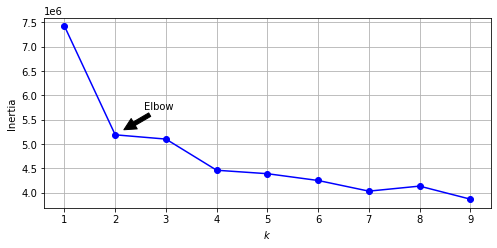

In [42]:
from sklearn.cluster import MiniBatchKMeans

kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42).fit(train_X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(2, inertias[1]), xytext=(2.85, inertias[1] * 1.1),
             arrowprops=dict(facecolor='black', shrink=0.2))
plt.text(2.85, inertias[1] * 1.1, "Elbow", horizontalalignment="center")
plt.grid()
plt.show()

Цим методом ми переконалися, що наш перший вибір у 2 кластири був вдалим. Спробуємо також вияснити чи буде це найкращим результатом і у випадку silhouette score.

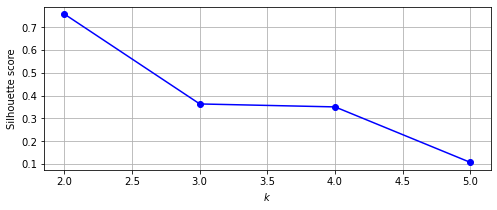

In [50]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(train_X, model.labels_) for model in kmeans_per_k[1:5]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 6), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

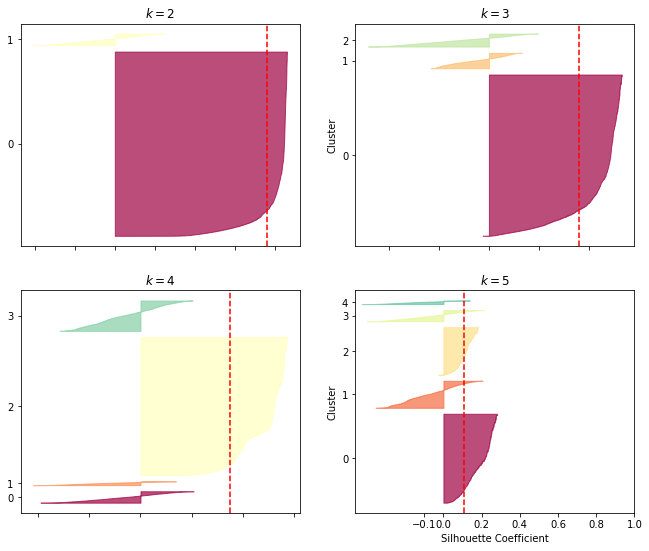

In [53]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(train_X, y_pred)

    padding = len(train_X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

Можемо помітити, що у всіх випадках є в наявності кластери, чий  silhouette score, менший за baseline, отже вони не можуть чітко розмежувати об'єкти між собою. Скоріш за все принележність до певного кластеру не повпливає на покращення моделі.

In [11]:
kmeans = MiniBatchKMeans(n_clusters=2)
train_X_clst = kmeans.fit_predict(train_X)
train_X_clst = np.concatenate((train_X, train_X_clst.reshape(-1, 1)), axis=1)
valid_X_clst = kmeans.predict(valid_X)
valid_X_clst = np.concatenate((valid_X, valid_X_clst.reshape(-1, 1)), axis=1)

clst_scores = train_models(models, train_X_clst, train_y['target_full_ltv_day30'], valid_X_clst, valid_y['target_full_ltv_day30'])
compare = 1 - np.array(clst_scores)[:, 1:].astype(np.float64) / np.array(baseline_scores)[:, 1:].astype(np.float64)
pd.DataFrame(np.concatenate((np.array(clst_scores)[:, [0]], compare), axis=1), columns=baseline_result.columns)

['LinearRegression', 3.533729286811778e+20, 492534453927699.44, 156929.20074402544, -99618788787037.53, 4.940018653869629, 0.017648935317993164]
['SGDRegressor', 3.432254278186839e+25, 3.404741378178683e+23, 10825174873.414907, -6.886344894707841e+22, 1.3764736652374268, 0.019787073135375977]
['PoissonRegressor', 427658165883929.94, 144227884973.5351, 1899.3490820105094, -29171171875.006413, 6.00055456161499, 0.020900487899780273]
['BayesianRidge', 150315353504279.72, 0.9499243410783438, 0.16301646864104952, 0.8078706747458497, 5.152355909347534, 0.01615762710571289]


/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['LinearSVR', 22043235304422.316, 1.2522311531788364, 0.09093444979786239, 0.7467268537941023, 63.886829137802124, 0.014295816421508789]
['KNeighborsRegressor', 8250707850592.587, 1.0124160744884352, 0.10209012057408526, 0.7952312527889247, 0.26007723808288574, 49.50549006462097]
['RandomForestRegressor', 4683782106839.775, 0.4425651563753957, 0.05711384549802626, 0.9104878765619613, 356.1336860656738, 0.3692789077758789]
['ExtraTreesRegressor', 2003580969900.109, 0.4147363701604327, 0.03275225816392367, 0.9161164573729902, 375.8398141860962, 0.31159114837646484]
['AdaBoostRegressor', 2.1579941728134416e+16, 66.76565747231514, 6.910538511564902, -12.503855165711228, 116.53150033950806, 1.780808925628662]
['GradientBoostingRegressor', 47320062004909.24, 0.6953027336586106, 0.09699858584943766, 0.8593698052693888, 96.51143765449524, 0.184523344039917]


,Model,mape,mse,mae,r2,training time,predicting time
0,LinearRegression,-3.1284519003763656,-169.4416607704219,-7.256851814333425,-225.12595175331572,-0.19305719315093373,-0.28130787738217466
1,SGDRegressor,-517.2158745401977,-3230690.505445659,-201.42257143695699,-4286176.382844291,-0.5318477987751795,-0.3808462139993023
2,PoissonRegressor,0.05289969799620686,-3211912986.7990727,-4708.903308096729,-4990225526.460761,-0.13737607078587355,-0.6601268819240613
3,BayesianRidge,0.08094259875080756,0.34888504209331805,0.027141068545635583,-0.038946504284455674,-0.10487215838138342,-0.08935718763562761
4,LinearSVR,0.03398195285533001,0.3935688067225558,0.04922660435750659,-0.08979197697157648,-0.31875200419353633,0.18483624943920896
5,KNeighborsRegressor,0.12522132905663863,0.40859325139157554,0.029788850431189173,-0.0760579630428575,-0.5447358135741069,-0.23383948418503353
6,RandomForestRegressor,0.6288873389161556,0.2568580243149151,-0.013202083042794799,-0.0014048815458713726,-0.015518851903054243,-0.23270798646372892
7,ExtraTreesRegressor,0.7943433508016773,0.004917135533012429,-0.04949522825702468,0.021724541917236162,0.20733217530024117,-0.03899568869911296
8,AdaBoostRegressor,-1.598817352413171,-4.779244582217627,-1.4014645075356125,-15.42620955377684,-0.36522993009145455,-0.4137296512376196
9,GradientBoostingRegressor,0.09220257179503866,0.18170600684692095,-0.04404616863543964,0.012743769557278073,-0.5839557764899621,-0.22611486663107483


In [12]:
pd.DataFrame(clst_scores, columns=baseline_result.columns).sort_values('mse')

,Model,mape,mse,mae,r2,training time,predicting time
7,ExtraTreesRegressor,2.003581e+12,4.147364e-01,3.275226e-02,9.161165e-01,375.839814,0.311591
6,RandomForestRegressor,4.683782e+12,4.425652e-01,5.711385e-02,9.104879e-01,356.133686,0.369279
9,GradientBoostingRegressor,4.732006e+13,6.953027e-01,9.699859e-02,8.593698e-01,96.511438,0.184523
3,BayesianRidge,1.503154e+14,9.499243e-01,1.630165e-01,8.078707e-01,5.152356,0.016158
5,KNeighborsRegressor,8.250708e+12,1.012416e+00,1.020901e-01,7.952313e-01,0.260077,49.505490
4,LinearSVR,2.204324e+13,1.252231e+00,9.093445e-02,7.467269e-01,63.886829,0.014296
8,AdaBoostRegressor,2.157994e+16,6.676566e+01,6.910539e+00,-1.250386e+01,116.531500,1.780809
2,PoissonRegressor,4.276582e+14,1.442279e+11,1.899349e+03,-2.917117e+10,6.000555,0.020900
0,LinearRegression,3.533729e+20,4.925345e+14,1.569292e+05,-9.961879e+13,4.940019,0.017649
1,SGDRegressor,3.432254e+25,3.404741e+23,1.082517e+10,-6.886345e+22,1.376474,0.019787


Неочікувано, але всі моделі, окрім SGDRegressor, отримали приріс (подекуди великий) у ефективності моделі. Що логічно, то час навчання та прогнозування зріс, подекуди дуже не значно зріс R2 score. Отже додаємо цю фічу до вирішення завдання.

Останнє, що ми ще спробуємо із кластеризацією, це поділити дані на велику купу кластерів (до прикладу 200) і використовувати як даті відстанні до кожного кластеру, оцінемо ефективність такої моделі.

In [14]:
kmeans = MiniBatchKMeans(n_clusters=180)
t_X_clst = kmeans.fit_transform(train_X)
val_X_clst = kmeans.transform(valid_X)

only_clst_scores = train_models(models, t_X_clst, train_y['target_full_ltv_day30'], val_X_clst, valid_y['target_full_ltv_day30'])
compare = 1 - np.array(only_clst_scores)[:, 1:].astype(np.float64) / np.array(baseline_scores)[:, 1:].astype(np.float64)
pd.DataFrame(np.concatenate((np.array(only_clst_scores)[:, [0]], compare), axis=1), columns=baseline_result.columns)

,Model,mape,mse,mae,r2,training time,predicting time
0,LinearRegression,0.9999982130959922,0.9999999999992596,0.9999884971648133,1.0000000000012634,-0.30301195415675974,-1.08471085108962
1,SGDRegressor,-60662.66961095807,-34201668.45938917,-27570.101537417377,-46490345.04355965,-6.935887036967756,-0.9175581917707949
2,PoissonRegressor,-0.9187148144836501,0.8925322044280958,-0.16470682103097456,0.999996349348745,0.9370428949736077,-2.452438216078025
3,BayesianRidge,0.1772413656058064,-0.46703837071268217,-0.27196273378415525,0.28435628769730925,-0.5030643960559158,-1.0111073604346505
4,LinearSVR,-6.598964684280218,-0.10580957202835073,-1.0462624365439406,0.2311494415829033,-2.3996279502203777,0.4933724866430106
5,KNeighborsRegressor,-0.6202418321595426,-0.2050625640610797,-0.2436401949361895,0.22531719257724814,0.9109064698485346,0.4066559626713554
6,RandomForestRegressor,0.07620428358787845,-0.9463445722893189,-0.43611694430624537,0.16432852158419542,-1.7902345237903474,-0.0104665747694348
7,ExtraTreesRegressor,0.20239896277505742,-1.3348668562460686,-0.5372323599886528,0.14749254132225176,-0.08655263427426774,-0.3348615939649737
8,AdaBoostRegressor,0.2639929894807791,0.46377093855163254,0.3363736703865359,0.6272500635478467,-1.2946186230360404,0.5318035768093383
9,GradientBoostingRegressor,-0.2592816924413748,-0.8932177564920074,-0.5660074889622528,0.23415196536926686,-6.025300168014662,0.4425326233842768


In [15]:
pd.DataFrame(only_clst_scores, columns=baseline_result.columns).sort_values('mse')

,Model,mape,mse,mae,r2,training time,predicting time
7,ExtraTreesRegressor,7.770516e+12,9.731393e-01,4.797338e-02,7.983397e-01,515.183949,0.400320
6,RandomForestRegressor,1.165915e+13,1.159111e+00,8.095341e-02,7.598013e-01,978.511137,0.302703
9,GradientBoostingRegressor,6.564161e+13,1.608663e+00,1.454921e-01,6.666422e-01,428.056029,0.083896
5,KNeighborsRegressor,1.528174e+13,2.062920e+00,1.308616e-01,5.725082e-01,0.015000,23.806814
0,LinearRegression,1.529492e+14,2.139678e+00,2.186222e-01,5.566019e-01,5.395302,0.028715
3,BayesianRidge,1.345653e+14,2.140291e+00,2.131356e-01,5.564748e-01,7.009248,0.029829
4,LinearSVR,1.733982e+14,2.283407e+00,1.957099e-01,5.268174e-01,164.694688,0.008885
2,PoissonRegressor,8.663856e+14,4.825739e+00,4.696880e-01,-2.134047e-05,0.332148,0.043465
8,AdaBoostRegressor,6.111622e+15,6.194873e+00,1.909674e+00,-2.837423e-01,195.861038,0.589765
1,SGDRegressor,4.017884e+27,3.604425e+24,1.474450e+12,-7.469326e+23,7.130956,0.027478


Отримали хороші результати, деякі моделі навіть показали себе краще, проте приріст не задовільний. При чому затрати часу на тренування зросли.

## Dimensionality Reduciton

### PCA

Text(0.5, 0, 'Principal Component #')

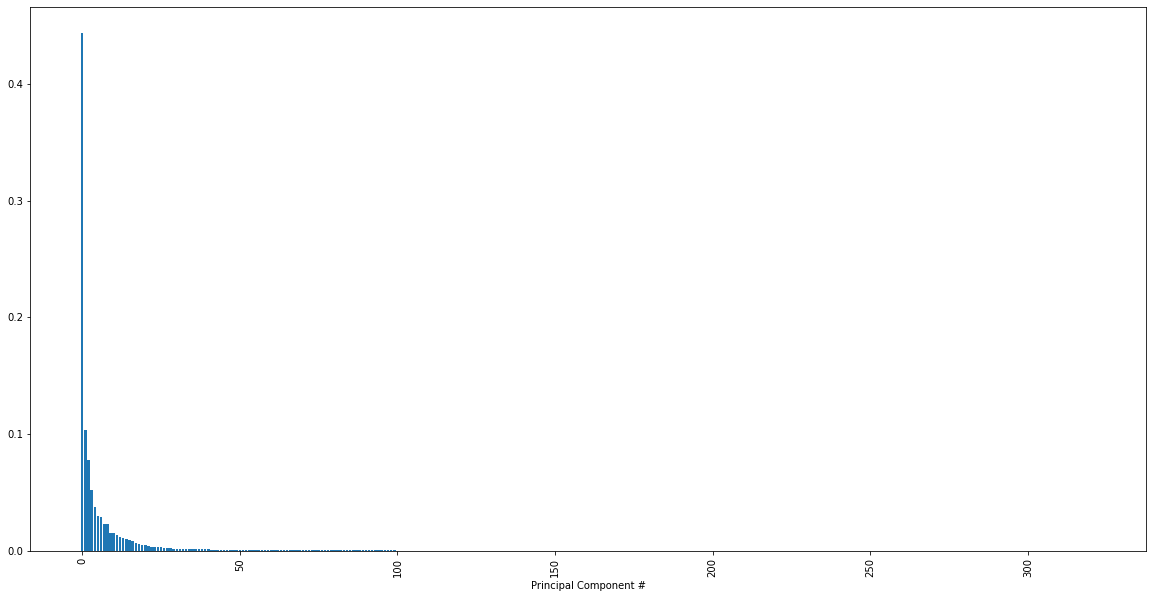

In [28]:
from sklearn.decomposition import PCA

pca = PCA()
train_X_pca = pca.fit_transform(train_X_clst)
exp_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
ax.bar(np.arange(train_X_clst.shape[1]), exp_variance)
ax.set_xlabel('Principal Component #')

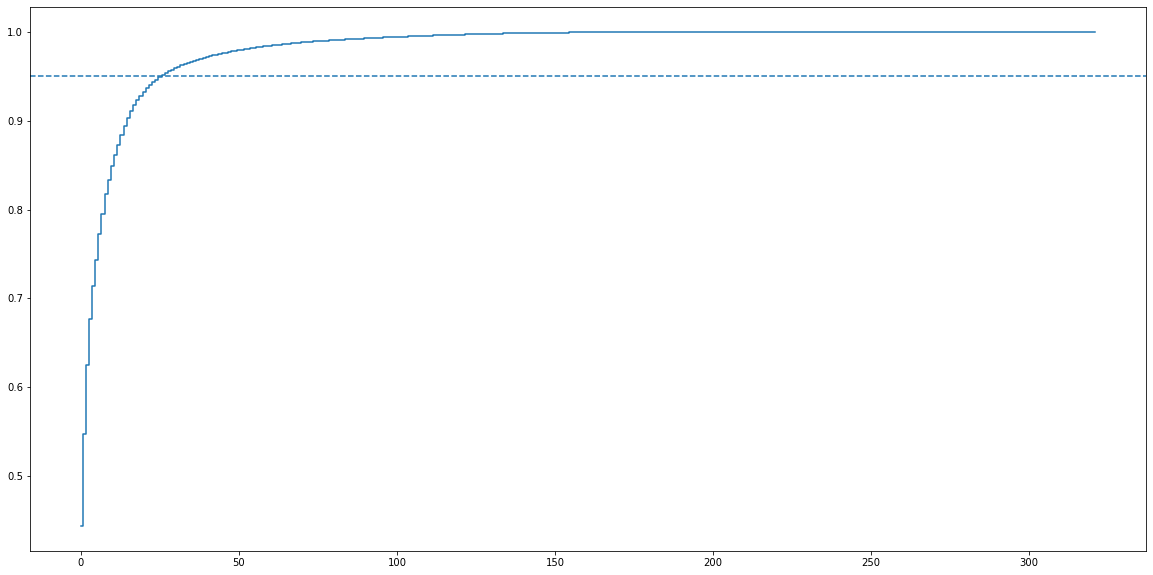

In [27]:
cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots(figsize=(20,10))
plt.step(range(0,len(cum_exp_variance)), cum_exp_variance, where='mid',label='Cumulative explained variance')
ax.axhline(y=0.95, linestyle='--')

In [35]:
pca = PCA(n_components=0.95)
train_X_pca = pca.fit_transform(train_X_clst)
valid_X_pca = pca.transform(valid_X_clst)

pca_scores = train_models(models, train_X_pca, train_y['target_full_ltv_day30'], valid_X_pca, valid_y['target_full_ltv_day30'])
compare = 1 - np.array(pca_scores)[:, 1:].astype(np.float64) / np.array(baseline_scores)[:, 1:].astype(np.float64)
pd.DataFrame(np.concatenate((np.array(pca_scores)[:, [0]], compare), axis=1), columns=baseline_result.columns)

['LinearRegression', 238929815753023.66, 1.3730473037350006, 0.1992017325676285, 0.715468100122923, 0.17697930335998535, 0.001378774642944336]
['SGDRegressor', 1.2769015270520598e+25, 7.33638088423436e+21, 5689220529.548809, -1.5202931359573533e+21, 0.33022284507751465, 0.001833200454711914]
['PoissonRegressor', 458189727904877.3, 4.173933532944571, 0.344557395121744, 0.13505001986546972, 1.0176973342895508, 0.0019757747650146484]
['BayesianRidge', 238792084385813.72, 1.3730625912042618, 0.1991498869409479, 0.7154649321529183, 0.255629301071167, 0.0033147335052490234]


/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['LinearSVR', 46207044387358.734, 1.955464175332214, 0.11479764468406131, 0.594775842437967, 42.00812840461731, 0.0023431777954101562]
['KNeighborsRegressor', 9099339507125.217, 1.2421364022413994, 0.09758326536416316, 0.7425963188050262, 0.012380838394165039, 6.647808313369751]
['RandomForestRegressor', 9109231014403.242, 0.6118781783469678, 0.06370076457665058, 0.8732025764117527, 229.05446362495422, 0.3416776657104492]
['ExtraTreesRegressor', 7452638611510.604, 0.543271783556705, 0.038295479613053025, 0.8874196451174626, 47.23682522773743, 0.3075542449951172]
['AdaBoostRegressor', 9744248111736156.0, 12.862298322659283, 3.1455295195978437, -1.6654101199402809, 21.272868633270264, 0.14594745635986328]
['GradientBoostingRegressor', 36673451859069.086, 0.8675126572887065, 0.11284816491375113, 0.8202283170621143, 91.69289660453796, 0.03173971176147461]


,Model,mape,mse,mae,r2,training time,predicting time
0,LinearRegression,0.9999972085856843,0.9999999999995248,0.9999895189730199,1.000000000001624,0.9572579689052235,0.8999013379952567
1,SGDRegressor,-191.79184696436877,-69612.4618485727,-105.3841150401577,-94624.61277814543,0.6325021312703326,0.8720696138295925
2,PoissonRegressor,-0.014716108078533185,0.9070477160007254,0.1455851741612001,1.023102604842357,0.8071003965653508,0.8430641037780512
3,BayesianRidge,-0.46002139766950245,0.0588496866389181,-0.18849799547087476,0.07989011925425338,0.9451828051886674,0.7765186221086302
4,LinearSVR,-1.0249676677201882,0.053006731027517406,-0.20027719627321194,0.13196915593431635,0.1328681627551761,0.8663893307231124
5,KNeighborsRegressor,0.03524542807151787,0.2744012373085415,0.07261964688406997,-0.0048356114954613005,0.9264636743664397,0.8343147725712367
6,RandomForestRegressor,0.2782433330436055,-0.027447262363458957,-0.1300543116591839,0.03960355200000998,0.3468488519202071,-0.1405709301252076
7,ExtraTreesRegressor,0.2350273297885609,-0.30347970773958055,-0.22711914752746032,0.05236844851759692,0.9003748137219613,-0.02553469909536621
8,AdaBoostRegressor,-0.17347495178748185,-0.11336232893263753,-0.09309534793536378,-1.1878352924414748,0.7507767696079518,0.88413678547472
9,GradientBoostingRegressor,0.2964492464610998,-0.020965921862981185,-0.21464342169505102,0.057710066795658044,-0.5048733784258366,0.7890969695145424


In [36]:
pd.DataFrame(pca_scores, columns=baseline_result.columns).sort_values('mse')

,Model,mape,mse,mae,r2,training time,predicting time
7,ExtraTreesRegressor,7.452639e+12,5.432718e-01,3.829548e-02,8.874196e-01,47.236825,0.307554
6,RandomForestRegressor,9.109231e+12,6.118782e-01,6.370076e-02,8.732026e-01,229.054464,0.341678
9,GradientBoostingRegressor,3.667345e+13,8.675127e-01,1.128482e-01,8.202283e-01,91.692897,0.031740
5,KNeighborsRegressor,9.099340e+12,1.242136e+00,9.758327e-02,7.425963e-01,0.012381,6.647808
0,LinearRegression,2.389298e+14,1.373047e+00,1.992017e-01,7.154681e-01,0.176979,0.001379
3,BayesianRidge,2.387921e+14,1.373063e+00,1.991499e-01,7.154649e-01,0.255629,0.003315
4,LinearSVR,4.620704e+13,1.955464e+00,1.147976e-01,5.947758e-01,42.008128,0.002343
2,PoissonRegressor,4.581897e+14,4.173934e+00,3.445574e-01,1.350500e-01,1.017697,0.001976
8,AdaBoostRegressor,9.744248e+15,1.286230e+01,3.145530e+00,-1.665410e+00,21.272869,0.145947
1,SGDRegressor,1.276902e+25,7.336381e+21,5.689221e+09,-1.520293e+21,0.330223,0.001833


За допомогою PCA, нам вдалося зменшити кількість вимірів до 30 та зберегти 95% варіативності данних. При цьому ми отримали результати дуже наближені до baseline, та значно виграли у часі навчання та прогнозування. Цей варіант можна розглядати як успішний, якщо на критичний час над точністю.

### T-SNE

<AxesSubplot:>

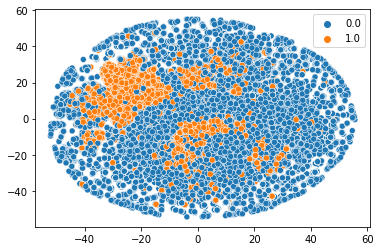

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE()
trian_X_tsne = tsne.fit_transform(train_X)

sns.scatterplot(x=trian_X_tsne[:, 0], y=trian_X_tsne[:, 1], hue=train_y_cl)

На жаль, T-SNE не зміг відокремити оркемі групи користувачів у візуалізації. Такий ж поганий результат показали Isomap та PCA з 2 компонентами, через технічні неможливості, було провірено на іншому пристрої.

Встановимо як новий baseline наш найкращий результат, тобто із кластерами.

In [ ]:
baseline_score = clst_scores
baseline_result = pd.DataFrame(baseline_score, columns=['Model', 'mape', 'mse', 'mae', 'r2', 'training time', 'predicting time'])
baseline_result.to_csv('basetable.csv', index=False)

## Voting Classifier

Отже зі всіх наших змін, найкраще себе показало добавлення приналежності до одно із 2 кластерів. Також ми робили припущення на початку моделювання, що через велику незбалансованість даних, варто спочатку класифікувати користувачів, як дохідних та не дохідних, і тільки опісля будувати регресійну модель. Для покращення результату класифікації скористаємося алгоритмом Voting.

In [6]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.metrics import confusion_matrix, accuracy_score


def train_cl(models, t_X, t_y, val_X, val_y):
    scores = []
    for mod in models:
        if str(mod())[:-2] not in ['KNeighborsClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']:
            model = mod(class_weight='balanced')
        else:
            model = mod()
        model.n_jobs = 6
        start = time.time()
        model.fit(t_X, t_y)
        fitting = time.time()
        pred = model.predict(val_X)
        prediciton = time.time()
        cf = confusion_matrix(val_y, pred)
    
        acc = np.round(accuracy_score(val_y, pred), decimals=4)
        precision_0 = np.round(cf[0][0] / (cf[0][0] + cf[1][0]), decbasetableimals=4)
        recall_0 = np.round(cf[0][0] / (cf[0][0] + cf[0][1]), decimals=4)
        f1_score_0 = np.round(2 * (precision_0 * recall_0) / (precision_0 + recall_0), decimals=4)
        precision_1 = np.round(cf[1][1] / (cf[1][1] + cf[0][1]), decimals=4)
        recall_1 = np.round(cf[1][1] / (cf[1][1] + cf[1][0]), decimals=4)
        f1_score_1 = np.round(2 * (precision_1 * recall_1) / (precision_1 + recall_1), decimals=4)
        fit_time = fitting - start
        pred_time = prediciton - fitting
        row = [str(mod())[:-2], acc, precision_0, recall_0, f1_score_0, precision_1, recall_1, f1_score_1, fit_time, pred_time]
        print(row)
        scores.append(row)

    return scores



models = [LogisticRegression, SGDClassifier, LinearSVC, KNeighborsClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier]
cl_scores = train_cl(models, train_X_clst, train_y_cl, valid_X_clst, valid_y_cl)

/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['LogisticRegression', 0.9762, 0.9836, 0.9854, 0.9845, 0.9519, 0.9461, 0.949, 114.95683526992798, 0.03619861602783203]
['SGDClassifier', 0.9705, 0.9859, 0.9754, 0.9806, 0.9222, 0.9542, 0.9379, 2.4625606536865234, 0.0187375545501709]


/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['LinearSVC', 0.9866, 0.988, 0.9945, 0.9912, 0.9816, 0.9604, 0.9709, 44.438058853149414, 0.017136096954345703]
['KNeighborsClassifier', 0.9352, 0.9412, 0.9765, 0.9585, 0.9121, 0.8001, 0.8524, 0.04105949401855469, 50.950324058532715]
['RandomForestClassifier', 0.9974, 0.9977, 0.9989, 0.9983, 0.9963, 0.9923, 0.9943, 26.433449268341064, 0.362135648727417]
['ExtraTreesClassifier', 0.9922, 0.9957, 0.9942, 0.9949, 0.9811, 0.9859, 0.9835, 65.12316465377808, 0.533850908279419]
['AdaBoostClassifier', 0.992, 0.9926, 0.997, 0.9948, 0.9901, 0.9755, 0.9827, 50.74998140335083, 1.8292536735534668]
['GradientBoostingClassifier', 0.993, 0.9932, 0.9977, 0.9954, 0.9924, 0.9777, 0.985, 211.8435742855072, 0.20693135261535645]


In [7]:
cl_result = pd.DataFrame(cl_scores, columns=['Model', 'accuracy', 'precision 0', 'recall 0', 'f1 score 0', 'precision 1', 'recall 1', 'f1 score 1', 'training time', 'predicting time'])
cl_result.sort_values('accuracy', ascending=False)

,Model,accuracy,precision 0,recall 0,f1 score 0,precision 1,recall 1,f1 score 1,training time,predicting time
4,RandomForestClassifier,0.9974,0.9977,0.9989,0.9983,0.9963,0.9923,0.9943,26.433449,0.362136
7,GradientBoostingClassifier,0.9930,0.9932,0.9977,0.9954,0.9924,0.9777,0.9850,211.843574,0.206931
5,ExtraTreesClassifier,0.9922,0.9957,0.9942,0.9949,0.9811,0.9859,0.9835,65.123165,0.533851
6,AdaBoostClassifier,0.9920,0.9926,0.9970,0.9948,0.9901,0.9755,0.9827,50.749981,1.829254
2,LinearSVC,0.9866,0.9880,0.9945,0.9912,0.9816,0.9604,0.9709,44.438059,0.017136
0,LogisticRegression,0.9762,0.9836,0.9854,0.9845,0.9519,0.9461,0.9490,114.956835,0.036199
1,SGDClassifier,0.9705,0.9859,0.9754,0.9806,0.9222,0.9542,0.9379,2.462561,0.018738
3,KNeighborsClassifier,0.9352,0.9412,0.9765,0.9585,0.9121,0.8001,0.8524,0.041059,50.950324


Оберемо 3 найкращі класифікатори для формування Voting classifier та оцінемо його ефективність.

In [24]:
from sklearn.ensemble import VotingClassifier

rfc = RandomForestClassifier(class_weight='balanced')
etc = ExtraTreesClassifier(class_weight='balanced')
gbc = GradientBoostingClassifier()

voting_clf = VotingClassifier(estimators=[('rfc', rfc), ('etc', etc), ('gbc', gbc)], voting='hard', n_jobs=6)
start = time.time()
voting_clf.fit(train_X_clst, train_y_cl)
fitting = time.time()
pred = voting_clf.predict(valid_X_clst)
prediction = time.time()

cf = confusion_matrix(valid_y_cl, pred)

acc = np.round(accuracy_score(valid_y_cl, pred), decimals=4)
precision_0 = np.round(cf[0][0] / (cf[0][0] + cf[1][0]), decimals=4)
recall_0 = np.round(cf[0][0] / (cf[0][0] + cf[0][1]), decimals=4)
f1_score_0 = np.round(2 * (precision_0 * recall_0) / (precision_0 + recall_0), decimals=4)
precision_1 = np.round(cf[1][1] / (cf[1][1] + cf[0][1]), decimals=4)
recall_1 = np.round(cf[1][1] / (cf[1][1] + cf[1][0]), decimals=4)
f1_score_1 = np.round(2 * (precision_1 * recall_1) / (precision_1 + recall_1), decimals=4)
fit_time = fitting - start
pred_time = prediction - fitting
row = ['Voting Classifier', acc, precision_0, recall_0, f1_score_0, precision_1, recall_1, f1_score_1, fit_time, pred_time]
pd.DataFrame([row], columns=['Model', 'accuracy', 'precision 0', 'recall 0', 'f1 score 0', 'precision 1', 'recall 1', 'f1 score 1', 'training time', 'predicting time'])

,Model,accuracy,precision 0,recall 0,f1 score 0,precision 1,recall 1,f1 score 1,training time,predicting time
0,Voting Classifier,0.9974,0.9976,0.999,0.9983,0.9968,0.9922,0.9945,241.030231,3.117654


In [13]:
from sklearn.ensemble import VotingClassifier

rfc = RandomForestClassifier(class_weight='balanced')
etc = ExtraTreesClassifier(class_weight='balanced')
gbc = GradientBoostingClassifier()

voting_clf = VotingClassifier(estimators=[('rfc', rfc), ('etc', etc), ('gbc', gbc)], voting='soft', n_jobs=6)
start = time.time()
voting_clf.fit(train_X_clst, train_y_cl)
fitting = time.time()
pred = voting_clf.predict(valid_X_clst)
prediction = time.time()

cf = confusion_matrix(valid_y_cl, pred)

acc = np.round(accuracy_score(valid_y_cl, pred), decimals=4)
precision_0 = np.round(cf[0][0] / (cf[0][0] + cf[1][0]), decimals=4)
recall_0 = np.round(cf[0][0] / (cf[0][0] + cf[0][1]), decimals=4)
f1_score_0 = np.round(2 * (precision_0 * recall_0) / (precision_0 + recall_0), decimals=4)
precision_1 = np.round(cf[1][1] / (cf[1][1] + cf[0][1]), decimals=4)
recall_1 = np.round(cf[1][1] / (cf[1][1] + cf[1][0]), decimals=4)
f1_score_1 = np.round(2 * (precision_1 * recall_1) / (precision_1 + recall_1), decimals=4)
fit_time = fitting - start
pred_time = prediction - fitting
row = ['Voting Classifier', acc, precision_0, recall_0, f1_score_0, precision_1, recall_1, f1_score_1, fit_time, pred_time]
pd.DataFrame([row], columns=['Model', 'accuracy', 'precision 0', 'recall 0', 'f1 score 0', 'precision 1', 'recall 1', 'f1 score 1', 'training time', 'predicting time'])

,Model,accuracy,precision 0,recall 0,f1 score 0,precision 1,recall 1,f1 score 1,training time,predicting time
0,Voting Classifier,0.9976,0.9978,0.9991,0.9984,0.9971,0.9927,0.9949,248.842814,2.140079


Ми натренували Voting classifier із hard та soft voting та отримали кращі результати при soft voting, на них і зупинемося.

### Confusion matrix

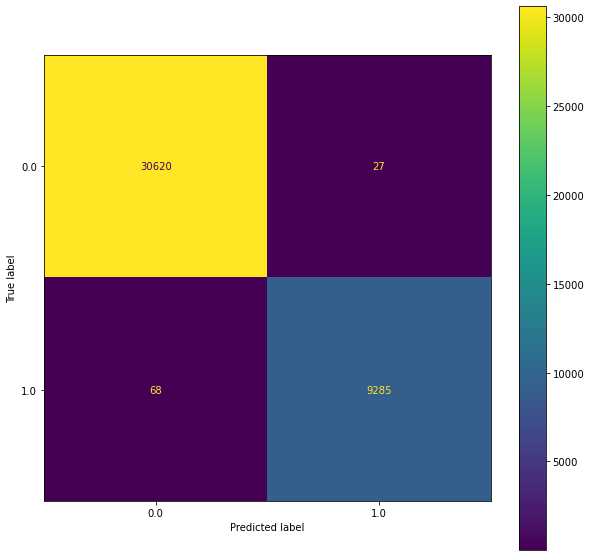

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cf = confusion_matrix(valid_y_cl, pred, labels=voting_clf.classes_)
cfdisp = ConfusionMatrixDisplay(cf, display_labels=voting_clf.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cfdisp.plot(ax=ax)

### Precisoin & Recall

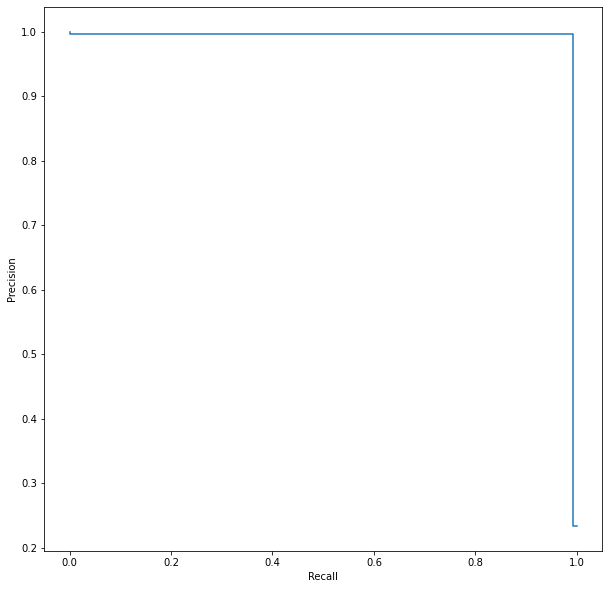

In [24]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, threshold = precision_recall_curve(valid_y_cl, pred, pos_label=voting_clf.classes_[1])
prdisp = PrecisionRecallDisplay(precision=prec, recall=recall)
fig, ax = plt.subplots(figsize=(10,10))
prdisp.plot(ax=ax)

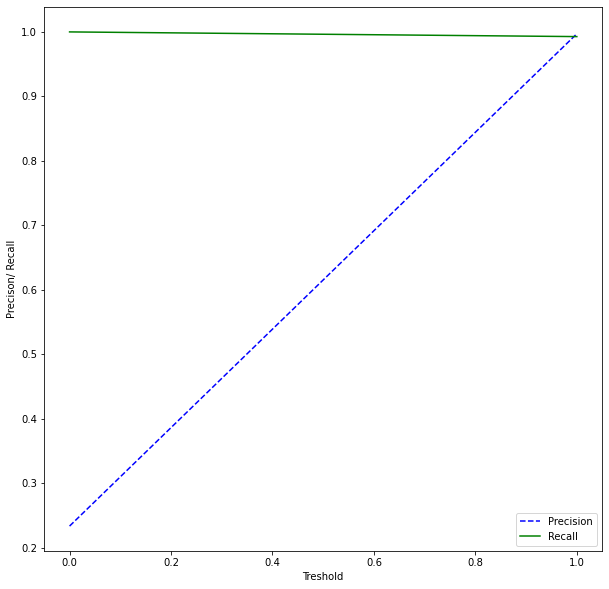

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,10))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlabel('Treshold')
    plt.ylabel('Precison/ Recall')

plot_precision_recall_vs_threshold(prec, recall, threshold)
plt.show()

### ROC curve

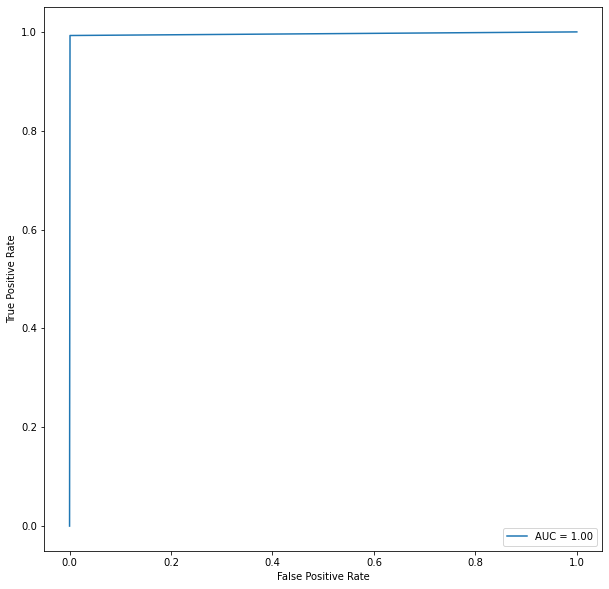

In [32]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

fpr, tpr, _ = roc_curve(valid_y_cl, pred, pos_label=voting_clf.classes_[1])
auc = roc_auc_score(valid_y_cl, pred)
radisp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
fig, ax = plt.subplots(figsize=(10,10))
radisp.plot(ax=ax)

### Learning curve

In [35]:
from sklearn.model_selection import learning_curve

train_size_abs, train_scores, test_scores = learning_curve(voting_clf, train_X_clst, train_y_cl, cv=3, scoring='f1')

plt.figure(figsize=(10, 10))
plt.plot(train_size_abs, train_scores, label='train')
plt.plot(train_size_abs, test_scores, label='valid')
plt.xlabel("Training Set Size")
plt.ylabel("F1 score")
plt.legend(loc="best")

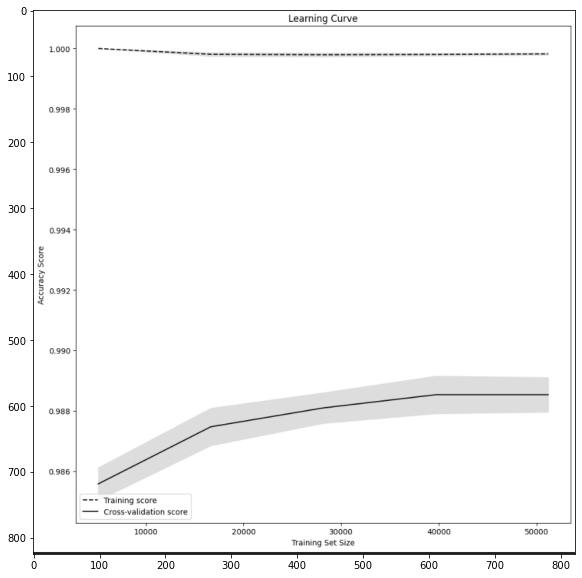

In [4]:
plt.figure(figsize=(10, 10))
lc = plt.imread('learning_curve.png')
plt.imshow(lc)

### Voting improvement

Перевіримо наскільки регресія краще впорається із даними, після класифікації. Оскільки наше передбачення досить точне, а алгоритми на базу Дерев Рішень будуть дуже оверфітити на тестовому датасеті, зразу застосуємо навчальні лейбли.

In [49]:
train_non_zeros_index = np.argwhere(train_y_cl == 1).flatten()
valid_non_zeros_index = np.argwhere(valid_y_cl == 1).flatten()

train_X_reg = train_X_clst[train_non_zeros_index]
train_y_reg = train_y.iloc[train_non_zeros_index]

valid_X_reg = valid_X_clst[valid_non_zeros_index]
valid_y_reg = valid_y.iloc[valid_non_zeros_index]

In [20]:
import time

from sklearn.linear_model import LinearRegression, SGDRegressor, PoissonRegressor, BayesianRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score


def train_models(models, t_X, t_y, val_X, val_y):
    scores = []
    for mod in models:
        model = mod()
        model.n_jobs = 6
        start = time.time()
        model.fit(t_X, t_y)
        fitting = time.time()
        pred = model.predict(val_X)
        prediction = time.time()

        mape = mean_absolute_percentage_error(val_y, pred)
        mse = mean_squared_error(val_y, pred)
        mae = mean_absolute_error(val_y, pred)
        r2 = r2_score(val_y, pred)
        fit_time = fitting - start
        pred_time = prediction - fitting

        row = [str(mod())[:-2], mape, mse, mae, r2, fit_time, pred_time]
        print(row)
        scores.append(row)
    
    return scores


models = [LinearRegression, SGDRegressor, PoissonRegressor, BayesianRidge, LinearSVR, KNeighborsRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor]
non_zero_scores = train_models(models, train_X_reg, train_y_reg['target_full_ltv_day30'], valid_X_reg, valid_y_reg['target_full_ltv_day30'])

['LinearRegression', 1831536280.1084816, 4.602945345735591e+16, 4436826.944315675, -1973521614528837.5, 0.628183126449585, 0.0031104087829589844]
['SGDRegressor', 3894677293035.1816, 1.0461239643478788e+22, 28457905603.464005, -4.485276491561735e+20, 0.16831660270690918, 0.005087852478027344]


/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


['PoissonRegressor', 127.1048721620569, 22900.138931205223, 3.048196949950543, -980.8478335467713, 2.1881701946258545, 0.0032999515533447266]
['BayesianRidge', 36.362271861951726, 6.189384021328869, 0.545019543787853, 0.7346289771172614, 0.9262039661407471, 0.006303310394287109]


/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['LinearSVR', 8.000788844238604, 7.1648662159437375, 0.3789542047975143, 0.6928049915806089, 8.370959758758545, 0.0044062137603759766]
['KNeighborsRegressor', 3.4209152581650435, 6.614776683759104, 0.4236807710689045, 0.7163901854108639, 0.008012771606445312, 2.059680223464966]
['RandomForestRegressor', 1.349103405292856, 4.004619576621359, 0.2280571813070742, 0.8283011702550517, 63.419028759002686, 0.13889241218566895]
['ExtraTreesRegressor', 0.8080552744476046, 3.907868571794008, 0.13117873280394243, 0.8324493880789078, 91.63292121887207, 0.14600253105163574]
['AdaBoostRegressor', 1344.3889157264714, 32.24141711607526, 5.0432363347172435, -0.38235692110843633, 15.945254564285278, 0.29797983169555664]
['GradientBoostingRegressor', 22.355747878457816, 4.828437524720669, 0.3807930380759617, 0.792979818275128, 35.04801607131958, 0.015903234481811523]


In [21]:
compare = 1 - np.array(non_zero_scores)[:, 1:].astype(np.float64) / np.array(baseline_scores)[:, 1:].astype(np.float64)
pd.DataFrame(np.concatenate((np.array(non_zero_scores)[:, [0]], compare), axis=1), columns=baseline_result.columns)

,Model,mape,mse,mae,r2,training time,predicting time
0,LinearRegression,0.9999999999786022,-15927.502928199656,-232.44426933526603,-4478.721735475888,0.8482883466361707,0.7741851730046896
1,SGDRegressor,0.9999999999411966,-99263.62629210777,-531.1412815335109,-27916.118511896322,0.8126840898845519,0.644942848110743
2,PoissonRegressor,0.9999999999997186,-508.97942366719025,-6.558754224950306,-166.79071881282127,0.5852429316958855,0.7378846700123093
3,BayesianRidge,0.9999999999997776,-3.242443679189253,-2.2525985589757664,0.05524456873972572,0.8013846494348806,0.5750269244988827
4,LinearSVR,0.9999999999996494,-2.4698053613967863,-2.962190092855251,-0.011097053218593445,0.8272066385533866,0.7487526679989663
5,KNeighborsRegressor,0.9999999999996373,-2.864047272549973,-3.026440615775962,0.03062491450933924,0.9524079255927768,0.9486660008579074
6,RandomForestRegressor,0.9999999999998931,-5.724435625278282,-3.0457442348402397,0.08898859980908347,0.819159990211449,0.5363564445321677
7,ExtraTreesRegressor,0.9999999999999171,-8.376204577565858,-3.203418690628933,0.11106846744261989,0.8067408890919605,0.5131569009831801
8,AdaBoostRegressor,0.9999999999998381,-1.7908215427723473,-0.75256284885313,0.49770092285719114,0.813192667127197,0.7634429401851244
9,GradientBoostingRegressor,0.9999999999995711,-4.682533997822309,-3.0986732844060505,0.08901352897540082,0.42478830634128517,0.8943266916870373


In [22]:
non_zero_result = pd.DataFrame(non_zero_scores, columns=['Model', 'mape', 'mse', 'mae', 'r2', 'training time', 'predicting time'])
non_zero_result.sort_values('mse')

,Model,mape,mse,mae,r2,training time,predicting time
7,ExtraTreesRegressor,8.080553e-01,3.907869e+00,1.311787e-01,8.324494e-01,91.632921,0.146003
6,RandomForestRegressor,1.349103e+00,4.004620e+00,2.280572e-01,8.283012e-01,63.419029,0.138892
9,GradientBoostingRegressor,2.235575e+01,4.828438e+00,3.807930e-01,7.929798e-01,35.048016,0.015903
3,BayesianRidge,3.636227e+01,6.189384e+00,5.450195e-01,7.346290e-01,0.926204,0.006303
5,KNeighborsRegressor,3.420915e+00,6.614777e+00,4.236808e-01,7.163902e-01,0.008013,2.059680
4,LinearSVR,8.000789e+00,7.164866e+00,3.789542e-01,6.928050e-01,8.370960,0.004406
8,AdaBoostRegressor,1.344389e+03,3.224142e+01,5.043236e+00,-3.823569e-01,15.945255,0.297980
2,PoissonRegressor,1.271049e+02,2.290014e+04,3.048197e+00,-9.808478e+02,2.188170,0.003300
0,LinearRegression,1.831536e+09,4.602945e+16,4.436827e+06,-1.973522e+15,0.628183,0.003110
1,SGDRegressor,3.894677e+12,1.046124e+22,2.845791e+10,-4.485276e+20,0.168317,0.005088


На жаль, після класифікації ми отримали значення на порядок нижчі за baseline. Отже цей метод не впливає позитивно на якість прогнозу.

## Splitting by cluster

Давайте ще спробуємо розділити наші датасети по кластерам на навчити регресію окремо по кожному із них.

In [34]:
train_zero_clst_index = np.argwhere(train_X_clst[:, -1] == 0).flatten()
train_ones_clst_index = np.argwhere(train_X_clst[:, -1] == 1).flatten()

valid_zero_clst_index = np.argwhere(valid_X_clst[:, -1] == 0).flatten()
valid_ones_clst_index = np.argwhere(valid_X_clst[:, -1] == 1).flatten()

train_X_0 = train_X_clst[train_zero_clst_index, :-1]
train_X_1 = train_X_clst[train_ones_clst_index, :-1]
train_y_0 = train_y.iloc[train_zero_clst_index]
train_y_1 = train_y.iloc[train_ones_clst_index]

valid_X_0 = valid_X_clst[valid_zero_clst_index, :-1]
valid_X_1 = valid_X_clst[valid_ones_clst_index, :-1]
valid_y_0 = valid_y.iloc[valid_zero_clst_index]
valid_y_1 = valid_y.iloc[valid_ones_clst_index]

Навчати будемо тільки на 4 найкращих моделях.

In [40]:
scores = []
for model in models:
    y_pred = valid_y['target_full_ltv_day30'].copy()
    model = model()

    start = time.time()
    model.fit(train_X_0, train_y_0['target_full_ltv_day30'])
    fitting = time.time()
    pred_0 = model.predict(valid_X_0)
    prediction = time.time()
    y_pred[valid_zero_clst_index] = pred_0

    start1 = time.time()
    model.fit(train_X_1, train_y_1['target_full_ltv_day30'])
    fitting1 = time.time()
    pred_1 = model.predict(valid_X_1)
    prediction1 = time.time()
    y_pred[valid_ones_clst_index] = pred_1

    mape = mean_absolute_percentage_error(valid_y['target_full_ltv_day30'], y_pred)
    mse = mean_squared_error(valid_y['target_full_ltv_day30'], y_pred)
    mae = mean_absolute_error(valid_y['target_full_ltv_day30'], y_pred)
    r2 = r2_score(valid_y['target_full_ltv_day30'], y_pred)
    fit_time = fitting - start + fitting1 - start1
    pred_time = prediction - fitting + prediction1 - fitting1

    row = [str(model)[:-2], mape, mse, mae, r2, fit_time, pred_time]
    print(row)
    scores.append(row)

['LinearRegression', 71384148705719.69, 2.860103591865294e+17, 7074730.717394253, -5.032281064380438e+16, 4.247229814529419, 0.016074657440185547]
['SGDRegressor', 7.363613189220578e+23, 7.804608834416348e+20, 4443606541.22439, -1.3732014939611131e+20, 1.3995518684387207, 0.014672279357910156]


/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


['PoissonRegressor', 199994479667934.38, 198.86131701721456, 0.3508145971378065, -33.98915364148869, 1.4450161457061768, 0.017199993133544922]
['BayesianRidge', 70506805495820.11, 1.3999372154429481, 0.1293937402744465, 0.753684532244494, 4.41176962852478, 0.015356779098510742]


/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['LinearSVR', 5423439524032.449, 1.6501378431149998, 0.08379783286520026, 0.7096623547082943, 41.94045877456665, 0.012144088745117188]
['KNeighborsRegressor', 5765402788894.442, 1.542349459834657, 0.09933588373960134, 0.7286274523951265, 0.02543044090270996, 30.88562321662903]
['RandomForestRegressor', 4008731341826.331, 0.918170623283273, 0.05414314862680817, 0.8384501647226903, 847.761367559433, 0.7971477508544922]
['ExtraTreesRegressor', 2652873244974.4663, 0.8356879903404991, 0.030785263865554354, 0.8529627786391485, 1401.3373546600342, 0.9026012420654297]
['AdaBoostRegressor', 2446270270181667.5, 10.048933716502152, 1.6252669350188407, -0.7680848694640443, 75.08181571960449, 1.2456400394439697]
['GradientBoostingRegressor', 16979618480136.066, 1.0835213587498282, 0.08379670224510126, 0.8093571144766657, 157.73309063911438, 0.12266874313354492]


In [41]:
compare = 1 - np.array(scores)[:, 1:].astype(np.float64) / np.array(baseline_scores)[:, 1:].astype(np.float64)
pd.DataFrame(np.concatenate((np.array(scores)[:, [0]], compare), axis=1), columns=baseline_result.columns)

,Model,mape,mse,mae,r2,training time,predicting time
0,LinearRegression,0.9999991660198039,-98972.95040805172,-371.2379447730738,-114227.38593288373,-0.02574270184591021,-0.16701573399339398
1,SGDRegressor,-10.117886203476532,-7404.63839188369,-82.09207685297851,-8546.038052112874,-0.557531032436966,-0.02390895629170009
2,PoissonRegressor,0.5570882372815467,-3.4285836058375416,0.1300689024268401,-4.814423324688785,0.7261041843467382,-0.36619638291828527
3,BayesianRidge,0.5689076337266787,0.04042877765361297,0.22779669471638275,0.030738539488365246,0.05393930126094881,-0.03536352092073791
4,LinearSVR,0.7623243418917744,0.20087033553494105,0.12384415061802612,-0.035699113524989556,0.13426499934037983,0.3075302146634571
5,KNeighborsRegressor,0.38872500633263896,0.09903062363003423,0.05596367783214451,0.014066198364675264,0.8489552061265875,0.23022878132111224
6,RandomForestRegressor,0.6823740041914226,-0.5417642378153369,0.03949820760933609,0.07782617484517051,-1.417400218953055,-1.6609979020689618
7,ExtraTreesRegressor,0.7276970431913563,-1.0050780665968695,0.013534048069981042,0.08916323215769184,-1.9555012286135183,-2.0097093707790314
8,AdaBoostRegressor,0.7054019094707642,0.1301629020542422,0.43520742223096454,-0.009026644478416834,0.12037567758609846,0.011124532684454347
9,GradientBoostingRegressor,0.6742596409410914,-0.275184141233912,0.09805256275506913,0.07019905863488707,-1.5887319278763536,0.18489462452809524


In [42]:
result = pd.DataFrame(scores, columns=['Model', 'mape', 'mse', 'mae', 'r2', 'training time', 'predicting time'])
result.sort_values('mse')

,Model,mape,mse,mae,r2,training time,predicting time
7,ExtraTreesRegressor,2.652873e+12,8.356880e-01,3.078526e-02,8.529628e-01,1401.337355,0.902601
6,RandomForestRegressor,4.008731e+12,9.181706e-01,5.414315e-02,8.384502e-01,847.761368,0.797148
9,GradientBoostingRegressor,1.697962e+13,1.083521e+00,8.379670e-02,8.093571e-01,157.733091,0.122669
3,BayesianRidge,7.050681e+13,1.399937e+00,1.293937e-01,7.536845e-01,4.411770,0.015357
5,KNeighborsRegressor,5.765403e+12,1.542349e+00,9.933588e-02,7.286275e-01,0.025430,30.885623
4,LinearSVR,5.423440e+12,1.650138e+00,8.379783e-02,7.096624e-01,41.940459,0.012144
8,AdaBoostRegressor,2.446270e+15,1.004893e+01,1.625267e+00,-7.680849e-01,75.081816,1.245640
2,PoissonRegressor,1.999945e+14,1.988613e+02,3.508146e-01,-3.398915e+01,1.445016,0.017200
0,LinearRegression,7.138415e+13,2.860104e+17,7.074731e+06,-5.032281e+16,4.247230,0.016075
1,SGDRegressor,7.363613e+23,7.804609e+20,4.443607e+09,-1.373201e+20,1.399552,0.014672


Не побачили значниш зрушень.

### Train model on different ltv

Ми знаємо, що наш таргет target_full_ltv_day30 скаладається із 3 доданків, спробуємо передбачити їх та просумувати.

In [4]:
train_y_ad = train_y['target_ad_ltv_day30']
train_y_iap = train_y['target_iap_ltv_day30']
train_y_sub = train_y['target_sub_ltv_day30']

valid_y_ad = valid_y['target_ad_ltv_day30']
valid_y_iap = valid_y['target_iap_ltv_day30']
valid_y_sub = valid_y['target_sub_ltv_day30']

In [5]:
scores = []
for model in models:
    model = model()

    start = time.time()
    model.fit(train_X_clst, train_y_ad)
    fitting = time.time()
    pred_0 = model.predict(valid_X_clst)
    prediction = time.time()
    y_pred = pred_0

    start1 = time.time()
    model.fit(train_X_clst, train_y_iap)
    fitting1 = time.time()
    pred_1 = model.predict(valid_X_clst)
    prediction1 = time.time()
    y_pred += pred_1

    start2 = time.time()
    model.fit(train_X_clst, train_y_sub)
    fitting2 = time.time()
    pred_2 = model.predict(valid_X_clst)
    prediction2 = time.time()
    y_pred += pred_2

    mape = mean_absolute_percentage_error(valid_y['target_full_ltv_day30'], y_pred)
    mse = mean_squared_error(valid_y['target_full_ltv_day30'], y_pred)
    mae = mean_absolute_error(valid_y['target_full_ltv_day30'], y_pred)
    r2 = r2_score(valid_y['target_full_ltv_day30'], y_pred)
    fit_time = fitting - start + fitting1 - start1 + fitting2 - start2
    pred_time = prediction - fitting + prediction1 - fitting1 + prediction2 - fitting2

    row = [str(model)[:-2], mape, mse, mae, r2, fit_time, pred_time]
    print(row)
    scores.append(row)

['LinearRegression', 129209047412695.47, 1.449556136802591, 0.14867703172710187, 0.744954206563169, 12.228063106536865, 0.05382037162780762]
['SGDRegressor', 3.1169851903034183e+25, 1.5056752649038054e+22, 14351953866.556627, -2.6491981431133716e+21, 4.426907062530518, 0.04909348487854004]
['PoissonRegressor', 463699578968051.7, 37867.79661069217, 1.393839010595139, -6661.744537498244, 7.204411029815674, 0.06313061714172363]
['BayesianRidge', 127167592858148.3, 1.4484494479226475, 0.14805963151054052, 0.7451489257163683, 14.005815982818604, 0.053760528564453125]


/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/archer/.config/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['LinearSVR', 23422949397847.656, 1.798744761386895, 0.08925792515621576, 0.6835153374120476, 142.16563868522644, 0.039361000061035156]
['KNeighborsRegressor', 5692834206094.024, 1.5463816743897856, 0.09956194494204117, 0.7279179942828048, 0.07140541076660156, 99.69836354255676]
['RandomForestRegressor', 5667158520857.163, 0.902756095886561, 0.0536031841179807, 0.8411623124419363, 1607.7252519130707, 1.4341399669647217]
['ExtraTreesRegressor', 2864714471886.373, 0.8726145805835073, 0.030702581504972706, 0.8464656370188048, 2299.6942253112793, 1.479358196258545]
['AdaBoostRegressor', 7870639664546588.0, 13.758038809063027, 2.931992185802386, -1.42069267626443, 190.25041127204895, 2.9715359210968018]
['GradientBoostingRegressor', 36420879263099.22, 1.053407982070189, 0.0869562667046968, 0.8146554881327988, 401.35912251472473, 0.2786448001861572]


In [7]:
compare = 1 - np.array(scores)[:, 1:].astype(np.float64) / np.array(baseline_score)[:, 1:].astype(np.float64)
pd.DataFrame(np.concatenate((np.array(scores)[:, [0]], compare), axis=1), columns=baseline_result.columns)

,Model,mape,mse,mae,r2,training time,predicting time
0,LinearRegression,0.9999984904521709,0.9999999999994984,0.999992177337211,1.000000000001691,-1.953182906734499,-2.9073442611600777
1,SGDRegressor,-469.61525032907286,-142869.5369359505,-267.37066752128214,-164889.56730823775,-3.926609211916859,-2.426002029848762
2,PoissonRegressor,-0.026918334113764875,-842.3048004242305,-2.4563667253874466,-1138.6048054184903,-0.36556123692887343,-4.01446832686299
3,BayesianRidge,0.2224725239927169,0.007176613409541233,0.11640132985557694,0.041715591684415854,-2.0034097812914653,-2.624568002443299
4,LinearSVR,-0.02648234359399071,0.12890289521999898,0.06675565995700661,0.0024605020377898024,-1.934583285378035,-1.2444090977065443
5,KNeighborsRegressor,0.39641906720159015,0.09667518997006885,0.05381531031275377,0.015026193395720422,0.5758856249504367,-1.4848108217264246
6,RandomForestRegressor,0.5509709394064195,-0.5158806313478459,0.049077201290160466,0.0748432049062604,-3.5844450156765904,-3.7873727791060086
7,ExtraTreesRegressor,0.7059526976703783,-1.0936765591279132,0.01618347585774349,0.09610120837645375,-3.8501876337920056,-3.932896187722452
8,AdaBoostRegressor,0.05215893571445107,-0.19089774982276175,-0.018889506048310745,-0.8663520412352892,-1.2288870813821564,-1.3590113351937627
9,GradientBoostingRegressor,0.3012946490946109,-0.2397440457796005,0.06404452913571557,0.0641122117720383,-5.587147762009634,-0.8515301345491828


In [8]:
result = pd.DataFrame(scores, columns=['Model', 'mape', 'mse', 'mae', 'r2', 'training time', 'predicting time'])
result.sort_values('mse')

,Model,mape,mse,mae,r2,training time,predicting time
7,ExtraTreesRegressor,2.864714e+12,8.726146e-01,3.070258e-02,8.464656e-01,2299.694225,1.479358
6,RandomForestRegressor,5.667159e+12,9.027561e-01,5.360318e-02,8.411623e-01,1607.725252,1.434140
9,GradientBoostingRegressor,3.642088e+13,1.053408e+00,8.695627e-02,8.146555e-01,401.359123,0.278645
3,BayesianRidge,1.271676e+14,1.448449e+00,1.480596e-01,7.451489e-01,14.005816,0.053761
0,LinearRegression,1.292090e+14,1.449556e+00,1.486770e-01,7.449542e-01,12.228063,0.053820
5,KNeighborsRegressor,5.692834e+12,1.546382e+00,9.956194e-02,7.279180e-01,0.071405,99.698364
4,LinearSVR,2.342295e+13,1.798745e+00,8.925793e-02,6.835153e-01,142.165639,0.039361
8,AdaBoostRegressor,7.870640e+15,1.375804e+01,2.931992e+00,-1.420693e+00,190.250411,2.971536
2,PoissonRegressor,4.636996e+14,3.786780e+04,1.393839e+00,-6.661745e+03,7.204411,0.063131
1,SGDRegressor,3.116985e+25,1.505675e+22,1.435195e+10,-2.649198e+21,4.426907,0.049093


Не отримали поліпшень.

## Stacking regression

Останнє, що ми спробує для підлищення ефективності поделі це створити Stacking Regressor на основі найкращих регресій.

In [5]:
from sklearn.ensemble import StackingRegressor

etr = ExtraTreesRegressor()
rf = RandomForestRegressor()
gbr = GradientBoostingRegressor()

stacking = StackingRegressor((('etr', etr), ('rf', rf), ('gbr', gbr)), cv=3, n_jobs=6, verbose=1)
start = time.time()
stacking.fit(train_X_clst, train_y['target_full_ltv_day30'])
fitting = time.time()
pred = stacking.predict(valid_X_clst)
prediction = time.time()

mape = mean_absolute_percentage_error(valid_y['target_full_ltv_day30'], pred)
mse = mean_squared_error(valid_y['target_full_ltv_day30'], pred)
mae = mean_absolute_error(valid_y['target_full_ltv_day30'], pred)
r2 = r2_score(valid_y['target_full_ltv_day30'], pred)
fit_time = fitting - start
pred_time = prediction - fitting

row = [str(stacking())[:-2], mape, mse, mae, r2, fit_time, pred_time]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


In [4]:
pd.DataFrame([row], columns=['Model', 'mape', 'mse', 'mae', 'r2', 'training time', 'predicting time'])

,Model,mape,mse,mae,r2,training time,predicting time
0,StackingRegressor,3.245360e+13,0.205492,0.065156,0.961864,1528.366679,1.477515


У результаті отримали модель, що в краще генералізує дані. Майже у двічі по метриці MSE. Саме цю модель реалізуємо у проекті.